# HMM GMM

We use 3-state mono-phone HMMs to construct this recognizer. The emission probability of every state is modeled by a GMM. Say we have F mono-phones (F = 39 in our English lexicon), and a G-mixture GMM for each mono-phone state. Thus the GMM-HMM has 3FG mixture components in total. Compared to GMM-UBM, these mixtures are better separated in the phoneme space.

MFCC:  MFCCs  are  extracted  from  16kHz  utterance  with  40 filter-banks distributed between 0 and 8kHz. Static 19-dimensional coefficients plus energy and their delta and delta-delta form a 60-dimensional vector. CMVN is applied per utterance.

Hmm, deepspeech ma 26 MFCC features i zdaje się, że usuwa co drugi, ale to w związku z jakąś sztuczką uczenia RNN. Mają tak: features = mfcc(audio, samplerate=fs, numcep=numcep) gdzie mfcc jest z psf jak u nas xD a numcep=26 domyślnie, a fs=16000 domyślnie

Hmm, inny papier: In our HMM-based method, a phoneme recognizer is firsttrained with 3-state, GMM-based, mono-phone HMMs. Thisrecognizer is the same as in speech recognition. LetFbe thetotal number of mono-phones (i.e. 39),S=3Fbe the numberof all states,Gthe number of Gaussian components per state,andC=SGthe number of all individual Gaussians, and let(s, g)denote Gaussian componentgin states.
3-state - what are you?

Given a transcription, a graph of HMM is composed.

The  Viterbi  and  forward-backward  (FB)  algorithms  are  twomeans to align frames to states and mixtures.

Speaker adaption is the same with Eq. 4 except mixtures here are phonetic dependent.

During the test phase,  the Viterbi-based log-likelihood ratio is expressed as:
sum_t log P(x_t | model_user,qt) - log P(x_t | model_ubm,qt)

HMM: To generate the alignment for the HMM-based modeling,we use MFCCs to train the HMM. 39 mono-phones plus a silencemodel are used,  each of which contains 3 states.  To model thecomplexity of silence, a GMM with 16 mixtures is used for every silence state, while other states are all modeled by 8 Gaussians,resulting 984 Gaussians in total. This HMM is further extended toa triphone system and remains 2142 senones.  The transcriptionsfor  DNN  training  is  generated  by  the  senone  alignment.   OnlyMFCCs are used for HMM training and alignment.

GMM-HMM and i-vector/HMM: The GMM of every state is re-estimated using the HMM alignments and different speaker fea-tures.   The total number of mixtures in our model is 984.   Thedimension of i-vector is again set to 600.  Viterbi and FB align-ments are both investigated

* 39 x 3 states

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import concurrent.futures as cf
import functools as ft
import itertools as it
import json
import math
import operator as op
import os
import re

from IPython.display import display
from ipywidgets import interact, interact_manual, widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pomegranate as pg
from scipy import interpolate, linalg, misc, optimize, spatial, stats
from sklearn import metrics, mixture, cluster, utils

from paprotka.dataset import reddots
from paprotka.feature import cepstral

In [3]:
%autoreload 0

In [4]:
import warnings
warnings.filterwarnings('once')

# Load

In [18]:
root = reddots.get_root()
load_pcm = ft.partial(reddots.load_pcm, root)
load_mfcc = ft.partial(reddots.load_npy, root, 'wac2_mfcc13_ddd_lifter22_hamming') # 'wac2_mfcc13_ddd_ne_hamming')

In [19]:
all_paths = [os.path.join(os.path.basename(root), file) for root, _, files in os.walk(root + '/pcm') 
                                      for file in files 
                                      if file.endswith('.pcm')]
print(len(all_paths), all_paths[0])

15305 f0002/20150224142650384_f0002_14438.pcm


In [20]:
all_mfcc = {path: load_mfcc(path) for path in all_paths}

In [8]:
def load_sets(eid, tid=None):
    tid = tid if tid else eid
    
    enrollments = reddots.load_enrollments(root + '/ndx/f_part_{}.trn'.format(eid), 
                                           root + '/ndx/m_part_{}.trn'.format(eid))
    trials = reddots.load_trials(root + '/ndx/f_part_{}.ndx'.format(tid), 
                                 root + '/ndx/m_part_{}.ndx'.format(tid))
    
    return enrollments, trials

In [9]:
enrollments_1, trials_1 = load_sets('01')
print('Enrollments', enrollments_1.dtypes, sep='\n')
print('Trials', trials_1.dtypes, sep='\n')

Enrollments
is_male                  bool
pcm_path               object
sentence_id             int16
speaker_id              int16
timestamp      datetime64[ns]
dtype: object
Trials
correct_sentence                  bool
expected_is_male                  bool
expected_sentence_id             int16
expected_speaker_id              int16
pcm_path                        object
target_person                     bool
trial_is_male                     bool
trial_sentence_id                int16
trial_speaker_id                 int16
trial_timestamp         datetime64[ns]
dtype: object


In [10]:
enrollments_2, trials_2 = load_sets('02')
enrollments_3, trials_3 = load_sets('03')
enrollments_4_td, trials_4_td = load_sets('04_td', '04')

In [21]:
trialed_paths = set(path for trials in (trials_1, trials_2, trials_3, trials_4_td) for path in trials.pcm_path)
untrialed_paths = [path for path in all_paths if path not in trialed_paths]
print(len(trialed_paths), len(untrialed_paths))

10857 4448


In [22]:
shit_lengths = np.array([mfcc.shape[0] for mfcc in all_mfcc.values()])
print(shit_lengths.min(), shit_lengths.mean(), shit_lengths.max(), shit_lengths)

shit_lengths_sorted = np.sort(shit_lengths)

print(shit_lengths_sorted[:40])
print(shit_lengths_sorted[-40:])

1 316.151323097 1219 [236 259 415 ..., 255 481 353]
[ 1  1  1  7  8  9  9  9 11 12 12 12 12 13 23 27 60 60 78 79 80 85 86 87 87
 87 89 89 89 89 89 89 89 89 91 91 92 92 93 93]
[1047 1047 1057 1058 1059 1059 1063 1065 1065 1067 1067 1067 1069 1069 1071
 1076 1078 1078 1078 1082 1086 1088 1088 1090 1181 1181 1181 1181 1181 1181
 1185 1185 1200 1200 1202 1202 1219 1219 1219 1219]


In [23]:
trialed_paths = [path for path in trialed_paths if all_mfcc[path].shape[0] >= 85]
untrialed_paths = [path for path in untrialed_paths if all_mfcc[path].shape[0] >= 85]

In [24]:
def with_opened_file(mode='r'):
    def decorator(fun):
        @ft.wraps(fun)
        def wrapped(path, *args, **kwargs):
            with open(path, mode=mode) as opened:
                return fun(opened, *args, **kwargs)
        return wrapped
    return decorator

def write_model(path, model):
    with open(path, 'w') as opened:
        opened.write(model.to_json())
        
def read_mvgaussian(path):
    with open(path, 'r') as opened:
        parsed = json.load(opened)
        means, covariance = parsed['parameters']
        return pg.MultivariateGaussianDistribution(means=means, covariance=covariance)
        
def read_gmm(path):
    with open(path, 'r') as opened:
        parsed = json.load(opened)
        distributions_parsed = parsed['distributions']
        weights_parsed = np.array(parsed['weights'])
        
        distributions = []
        for i, distribution in enumerate(distributions_parsed):
            try:
                distribution = pg.MultivariateGaussianDistribution(*distribution['parameters'])
                distributions.append(distribution)
            except Exception as exception:
                raise IOError('Cannot read mixture at {}'.format(i)) from exception
                        
        weights_exp = np.exp(weights_parsed) * weights_parsed.sum()
        
        return pg.GeneralMixtureModel(distributions=distributions, weights=weights_exp)

# Train

In [25]:
untrialed_features = [all_mfcc[path] for path in untrialed_paths]
untrialed_features_stack = np.vstack(untrialed_features)

print(len(untrialed_features), untrialed_features_stack.shape)

4445 (1442782, 39)


In [26]:
corrcoef = np.corrcoef(untrialed_features_stack, rowvar=False)

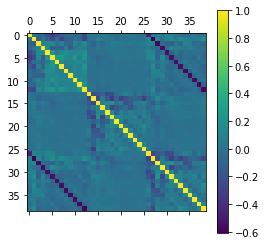

In [27]:
plt.matshow(corrcoef)
plt.colorbar()
plt.show()

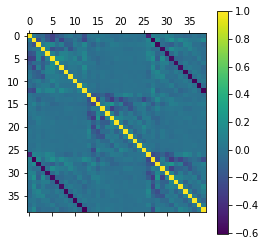

In [34]:
plt.matshow(corrcoef)
plt.colorbar()
plt.show()

In [24]:
for i in range(10, 13):
    print(untrialed_features_stack[i])

[  1.36439538e+01   1.06402371e+01   9.85238904e+00  -1.40216047e+01
  -6.60928399e+00  -6.24323575e+01  -9.92549826e+00  -2.48692005e+00
   1.65280296e+00  -1.91501933e+01  -1.13933064e+00  -1.79754092e+01
  -9.04917908e+00  -3.23053425e-01  -1.30709344e-01   1.46158669e+00
   2.35744100e+00  -3.50560148e-03   3.23599833e+00   4.25554920e-01
  -8.48638973e-01  -2.48333816e+00   2.28164573e+00   1.09627431e-01
  -2.39027954e+00   9.21418808e-01  -1.64774332e-02  -2.78515017e-01
  -9.53002390e-03   7.07058210e-01  -2.64383775e-01   5.50964265e-01
   8.98696529e-03   1.70201713e-01  -7.14107391e-01   1.72206484e-01
   1.58478708e-01   1.72206701e-01   4.99866536e-01]
[  1.30229907e+01   8.93791772e+00   1.05686586e+01  -9.34823552e+00
  -3.70331599e+00  -4.72091814e+01  -9.27835882e+00   5.43021522e+00
  -1.17540653e+00  -8.39103005e+00  -5.45634242e+00  -2.03610971e+01
  -3.97790812e+00  -3.24115882e-01  -2.10181459e-01   1.60707517e+00
   4.05581448e+00  -2.92949867e-01   3.60744184e+0

## Make 512 mixture GMM

In [29]:
ubm_model = pg.GeneralMixtureModel.from_samples(
    pg.MultivariateGaussianDistribution, n_components=512, 
    X=untrialed_features_stack,
    max_iterations=1e5, verbose=True, n_jobs=20
)

[1] Improvement: 2972073.791748643	Time (s): 84.39
[2] Improvement: 1303277.9997297227	Time (s): 86.98
[3] Improvement: 690833.9474477917	Time (s): 85.47
[4] Improvement: 440932.5858758539	Time (s): 83.1
[5] Improvement: 319079.4704605192	Time (s): 84.75
[6] Improvement: 245159.84085182846	Time (s): 85.7
[7] Improvement: 192845.16671431065	Time (s): 80.82
[8] Improvement: 151513.38902549446	Time (s): 82.97
[9] Improvement: 123842.77233706415	Time (s): 83.91
[10] Improvement: 104035.3292106241	Time (s): 82.5
[11] Improvement: 90430.34348393977	Time (s): 74.97
[12] Improvement: 84201.54341229796	Time (s): 77.75
[13] Improvement: 69003.20399394631	Time (s): 86.22
[14] Improvement: 78160.33592446148	Time (s): 87.1
[15] Improvement: 65047.988532587886	Time (s): 84.65
[16] Improvement: 60434.31527197361	Time (s): 84.4
[17] Improvement: -59754.34675942361	Time (s): 79.79
Total Improvement: 6931117.677261636
Total Time (s): 1486.1410


In [ ]:
ubm_model.freeze()

In [ ]:
write_model(root + '/models/ubm_model', ubm_model)

In [113]:
# ubm_model = read_gmm(root + '/models/ubm_model')

In [33]:
ubm_model2 = pg.GeneralMixtureModel.from_samples(
    pg.MultivariateGaussianDistribution, n_components=512, 
    X=untrialed_features_stack,
    max_iterations=1, verbose=True, n_jobs=20
)

corrector = 1e-6 * np.eye(39)
for i in range(1000):
    for distribution in ubm_model.distributions:
        distribution.parameters[1] += corrector
    logp = ubm_model2.summarize(untrialed_features_stack)
    print(logp)
    ubm_model2.from_summaries()

[1] Improvement: 3083619.639552921	Time (s): 84.97
Total Improvement: 3083619.639552921
Total Time (s): 161.6787
-104150617.06582461
-102797180.2905831
-102083937.38561195
-101626808.26803866
-101313149.11234453
-101076141.77561331
-100872329.08532082
-100723552.8246057


LinAlgError: 36-th leading minor not positive definite

## Maybe sklearn?

In [36]:
gmm = mixture.GaussianMixture(n_components=512, max_iter=2000, covariance_type='diag', random_state=13, verbose=1)

In [37]:
gmm.fit(untrialed_features_stack)

Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True


GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=2000,
        means_init=None, n_components=512, n_init=1, precisions_init=None,
        random_state=13, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

## Enroll

In [38]:
def map_adaptation(speaker_features, gmm, relevance_factor):
    pass

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=2000,
        means_init=None, n_components=512, n_init=1, precisions_init=None,
        random_state=13, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

In [54]:
def make_speaker_classifier(inspeaker_classifier):
    n_components = 3 * len(phones)
    initial, transitions = make_matrix_beads(n_components)

    classifier = hmm.GMMHMM(
        n_components=n_components, n_mix=8, covariance_type='diag', init_params='mcw', params='tmcw'
    )

    classifier.startprob_ = initial
    classifier.transmat_ = transitions

GMMHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
    init_params='stmcw', n_components=39, n_iter=10, n_mix=8,
    params='stmcw', random_state=None, startprob_prior=1.0, tol=0.01,
    transmat_prior=1.0, verbose=False)

In [ ]:
def perform_enrollments(classifier, enrollments):
    labels = enrollments[['is_male', 'speaker_id', 'sentence_id']].values
    features = [load_mfcc(path) for path in enrollments_1['pcm_path']]
    classifier.fit(features, labels)
    

## Trial

In [ ]:
def save_results(label, results):
    path = os.path.join(root, 'result', label)
    with open(path) as opened:
        pickle.dump(results, opened)
        
def load_results(label):
    path = os.path.join(root, 'result', label)
    with open(path) as opened:
        return pickle.load(opened)
    
def perform_trial(classifier, path):
    features = load_mfcc(path)
    return classifier.predict_single_proba(features)

def perform_trials(classifier, trials):
    paths = trials['pcm_path'].unique()
    results = {}
    for path in paths:
        results[path] = perform_trial(classifier, path)
    return results

In [10]:
per_phone_weights = {}

per_phone_weights.get('A', np.eye(3))

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [ ]:
class Bakis:
    def __init__(self, phones, per_phone_weights, ignore_stress=True, wrap_silence=True):
        self.phone_seq = phones.split(' ')
        if wrap_silence:
            self.phone_seq = ['_'] + self.phone_seq + ['_']
            
        state_transitions = 

In [51]:
enrollments_1.sentence_id.unique()

array([31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

In [52]:
sample_enrollments = enrollments_1.loc[enrollments_1.sentence_id == 31]

In [ ]:
class HmmGmmVerifier:
    def __init__(self):
        self.patterns = None
        self.labels = None

    def fit(self, features, labels):
        self.patterns = features
        self.labels = labels
        self.unique_labels = np.unique(labels)
        
    def enroll(self, ):
        pass
    
    def trial(self, ):
        pass

    def predict(self, features, metric=spatial.distance.cosine):
        sequence_label_proba = self.predict_proba(features, metric)
        max_proba_index = sequence_label_proba.argmax(axis=1)
        return self.unique_labels[max_proba_index]
    
    def predict_proba(self, features, metric=spatial.distance.cosine):
        sequence_n = len(features) 
        pattern_n = len(self.patterns)
        
        sequence_label_proba = np.zeros((sequence_n, pattern_n), dtype=self.labels.dtype)
        for i, sequence in enumerate(features):
            sequence_label_proba[i, :] = self.predict_single_proba(sequence, metric)
            
        return sequence_label_proba
    
    def predict_single_proba(self, sequence, metric=spatial.distance.cosine):
        pattern_dists = np.zeros(len(self.patterns), dtype=np.float64)
        for i, pattern in enumerate(self.patterns):
            distance, _ = fastdtw.fastdtw(pattern, sequence, dist=metric)
            pattern_dists[i] = distance
            
        pattern_proba = np.exp(-pattern_dists)
        
        label_proba = np.zeros(len(self.unique_labels), dtype=np.float64)
        all_dim = tuple(range(1, self.labels.ndim))
        for i, label in enumerate(self.unique_labels):
            relevant = (self.labels == label).all(axis=all_dim)
            total_proba = pattern_proba[relevant].sum()
            label_proba[i] = total_proba
        
        return label_proba / label_proba.sum()

classifier = markov.HMMGMMClassifier()
classifier.fit(e_features, e_labels, n_components=10, n_mix=2)
return classifier.predict(t_features)

In [5]:
display(enrollments_1.groupby(['is_male', 'speaker_id']).size())

is_male  speaker_id
False    2             30
         4             30
         5             30
         6             30
         8             24
         12            30
True     1             30
         2             30
         4             30
         5             30
         6             30
         7             30
         8              6
         9             30
         13            30
         14            24
         15            30
         16            30
         17            30
         18            30
         19            30
         20            30
         21            24
         22            30
         23            30
         26            30
         28            30
         29            30
         32            30
         38            24
         40            30
         41            30
         43            30
         47            30
         48             6
         51            30
         52             6
         53       